# Import Modules

In [1]:
import scanpy as sc
import squidpy as sq
import sys
sys.path.append(r"/home/yqzhou/JUPYTER/MyPackage/Pianno")
import pianno as po
import json
from os.path import join
import matplotlib.pyplot as plt
import matplotlib as mpl

# Data input

In [2]:
# Setting the data and configuration file storage path.
sample_name = "MB"
config_path = "/home/yqzhou/JUPYTER/Revision/Tutorials/" + sample_name
adata = sc.read(join(config_path, "MB.h5ad"))

# (Optional) Step1：Automatic hyper-parameter selection

In [3]:
# Specify a known marker gene for each pattern
Patterndict = {
               "CTX": ['Mef2c'],
               "Mb": ['Sparc'],
               "Th": ['Prkcd'],
               "SNr": ['Slc6a3'],
               "Hip": ['Cpne6'],
               "FT": ['Mbp']
              }

Configuration path of Pianno: /home/yqzhou/JUPYTER/Revision/Tutorials/MB
[2024-01-18 01:08:55] Creating experiment, Experiment ID: gevw2qis
[2024-01-18 01:08:56] Starting web server...
[2024-01-18 01:08:57] Timeout, retry...
[2024-01-18 01:08:58] Setting up...
[2024-01-18 01:08:58] Web UI URLs: http://127.0.0.1:8080 http://10.10.10.7:8080 http://11.11.11.7:8080
[2024-01-18 01:19:09] Stopping experiment, please wait...
[2024-01-18 01:19:12] Experiment stopped


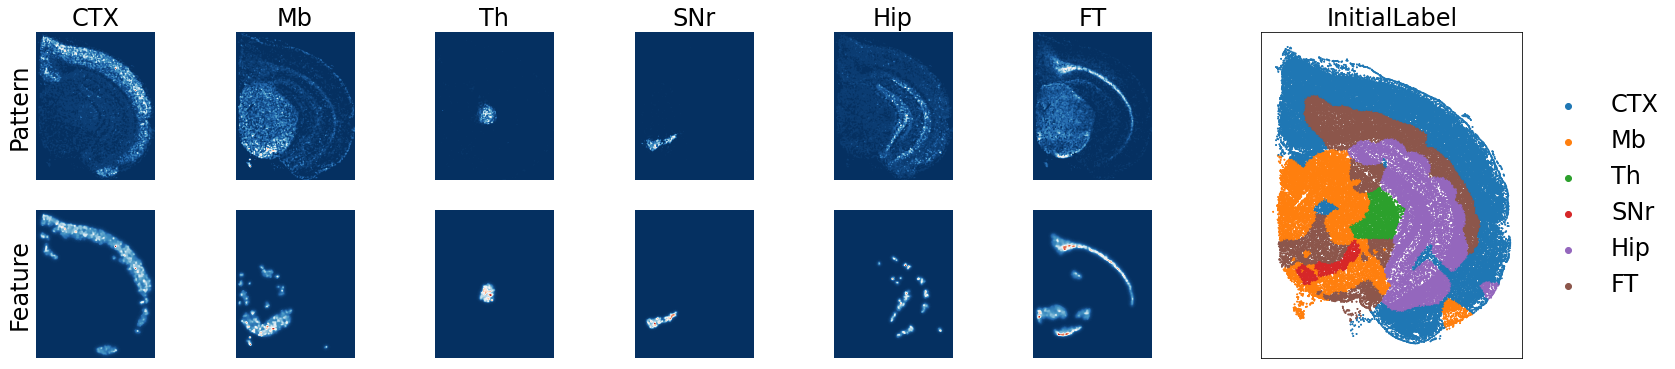

In [4]:
# If the connection fails, try a few more times.
# Open the Web UI URLs to visualize the hyperparameter tuning process.
# The default experiment lasts for a maximum of 10 minutes, 
# which can be modified according to the actual situation.
adata = po.AutoPatternRecognition(adata,
                                  Patterndict=Patterndict,
                                  config_path=config_path,
                                  param_tuning=True,
                                  max_experiment_duration='10m')

In [5]:
# Print the optimal parameters saved in the previous step.
with open(join(config_path, "best_params.json"),'r') as f:
    best_params_dict = json.load(f)
for key in best_params_dict:
    best_params = best_params_dict[key]  
best_params

{'n_class': 2,
 'dilation_radius': 3.0,
 'denoise_weight': 0.05,
 'unsharp_radius': 1.0,
 'unsharp_amount': 5.0,
 'gaussian_blur': 1.0}

# (Optional) Step2：Marker Selection

In [6]:
# Take the top 10 DEGs as candidate marker genes to make a proposed patterndict
Patterndict = po.ProposedPatterndict(adata, top_n=10)

CTX
['Mef2c', 'Egr1', 'Arpp21', 'Satb2', 'Rgs4', 'Plxnd1', 'Cabp1', 'Stx1a', 'Lamp5', 'Camk2n1']


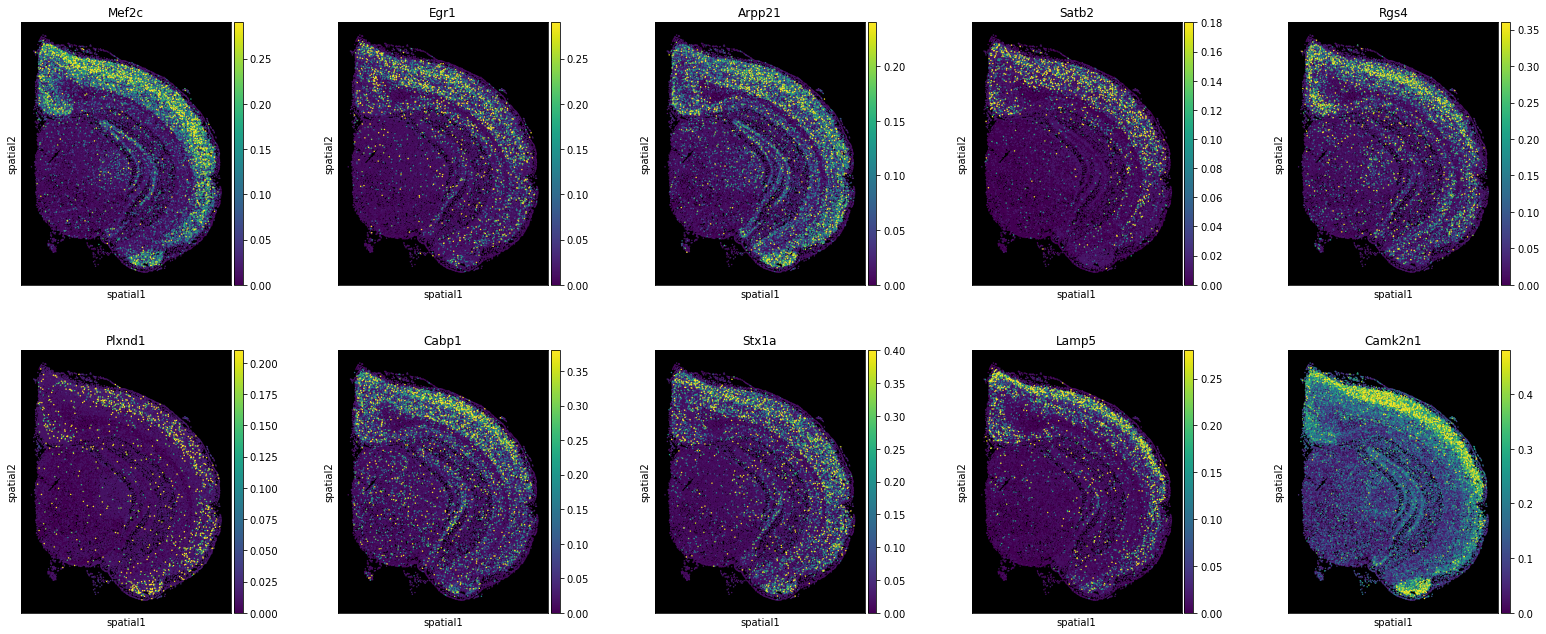

Mb
['Sparc', 'Cacna2d2', 'Slc17a6', 'Mbp', 'Ankrd34b', 'Calb2', 'Tcf7l2', 'Phlda3', 'Vamp1', 'Mobp']


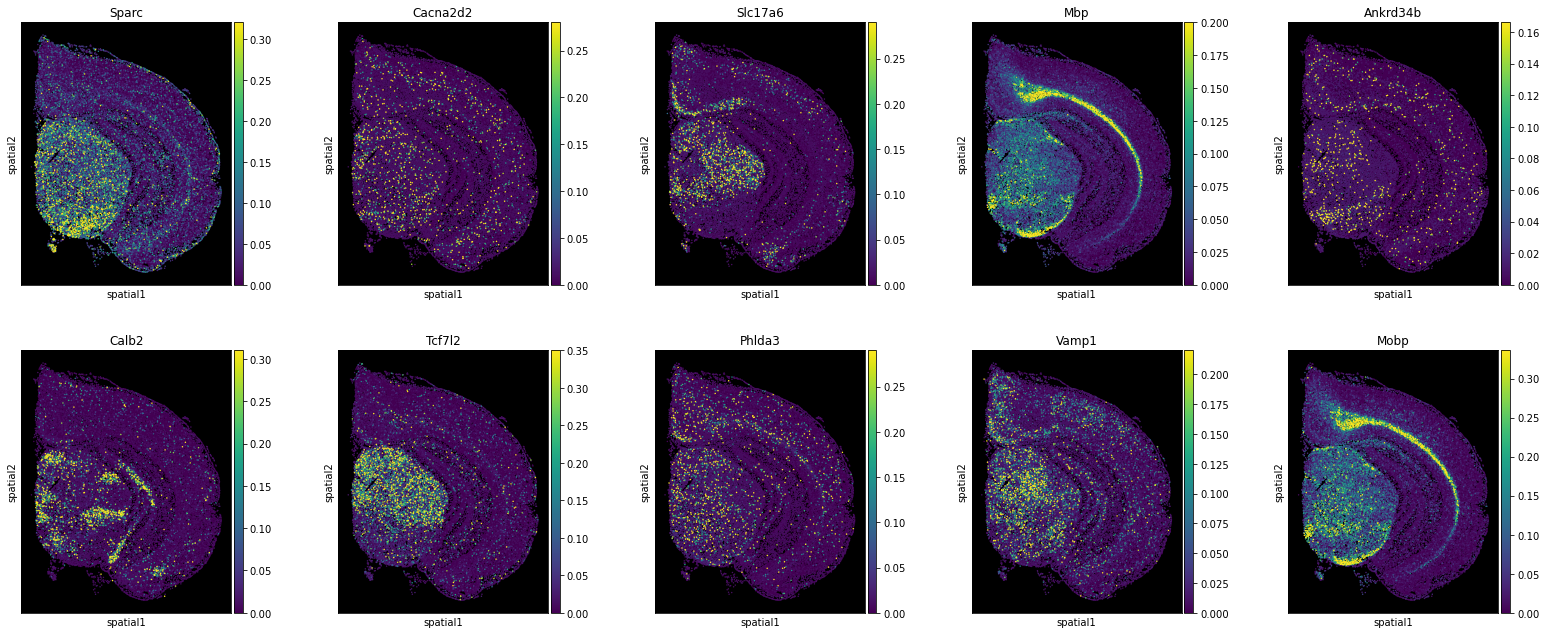

Th
['Prkcd', 'Amotl1', 'Adarb1', '9330185C12Rik', 'Slc17a6', 'Pdp1', 'Camk1d', 'Zic1', 'Il31ra', 'Rsph3b']


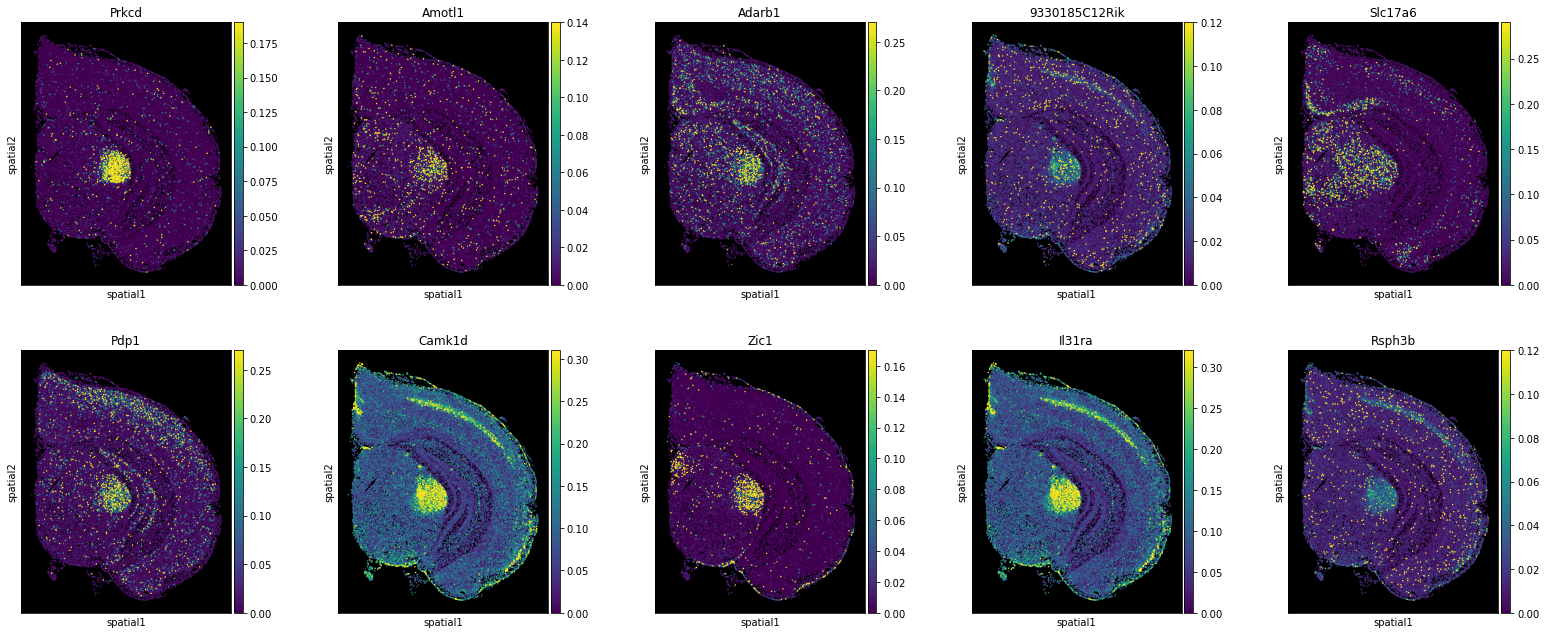

SNr
['Ankrd34b', 'Sncg', 'Dlk1', 'Ret', 'Ddc', 'Th', 'Slc18a2', 'Sv2c', 'Aldh1a1', 'Slc6a3']


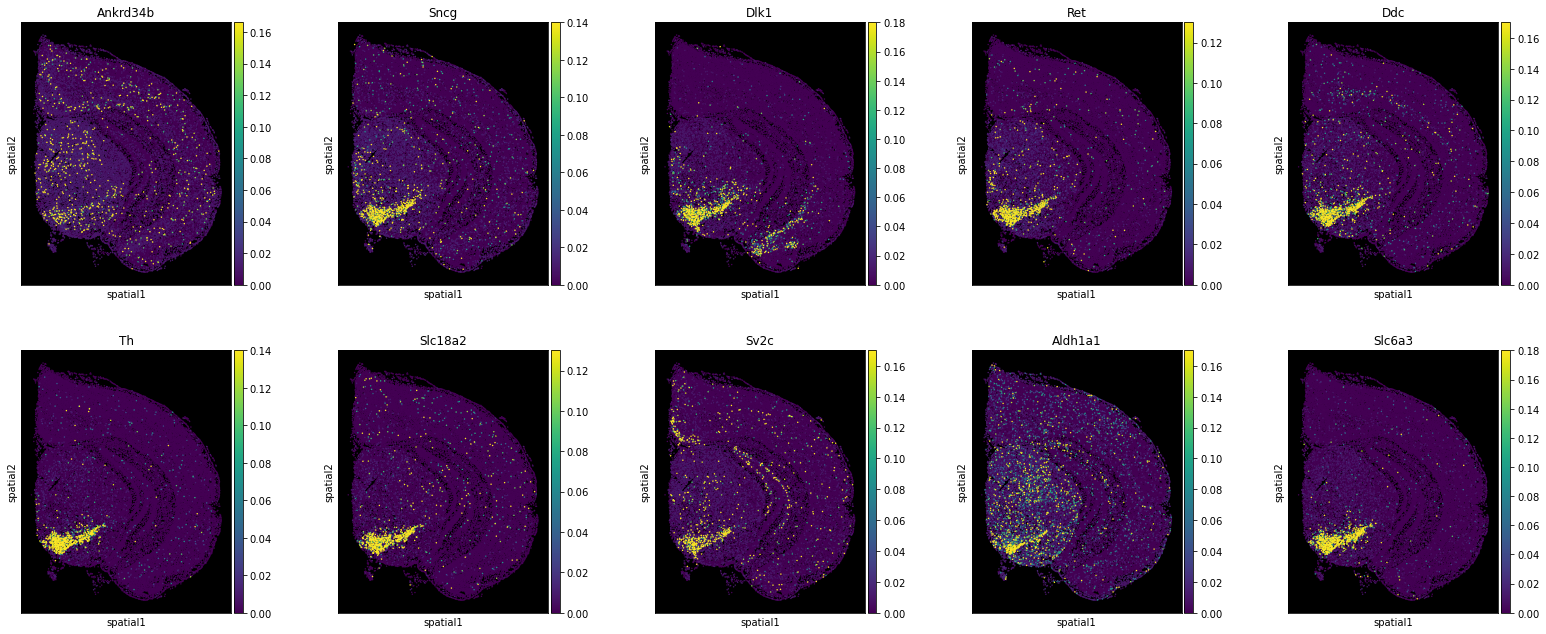

Hip
['Cpne6', 'Gabra5', 'Stum', 'Cnih2', 'Syt17', 'St6galnac5', 'Crym', 'Ptk2b', 'Snca', 'Cpne7']


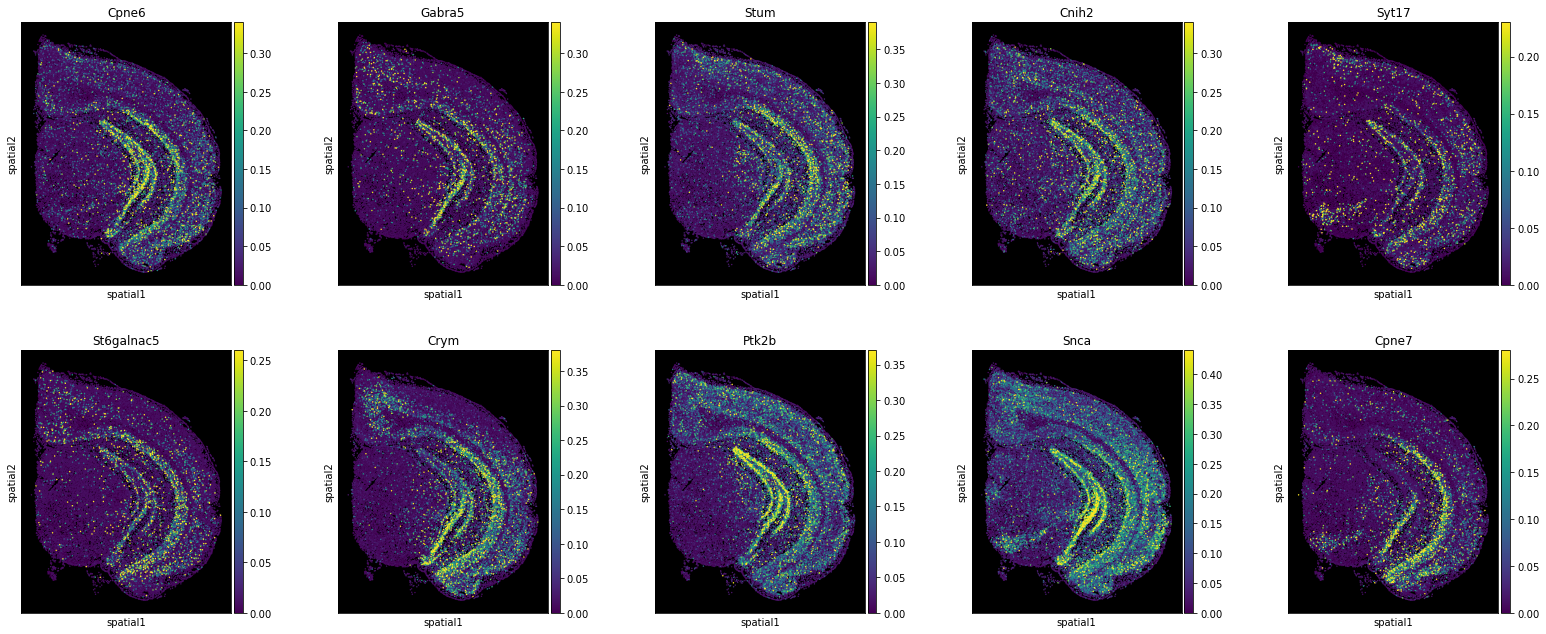

FT
['Cnp', 'Mbp', 'Mobp', 'Plp1', 'Cldn11', 'Mal', 'Plekhb1', 'Cryab', 'Qdpr', 'Fth1']


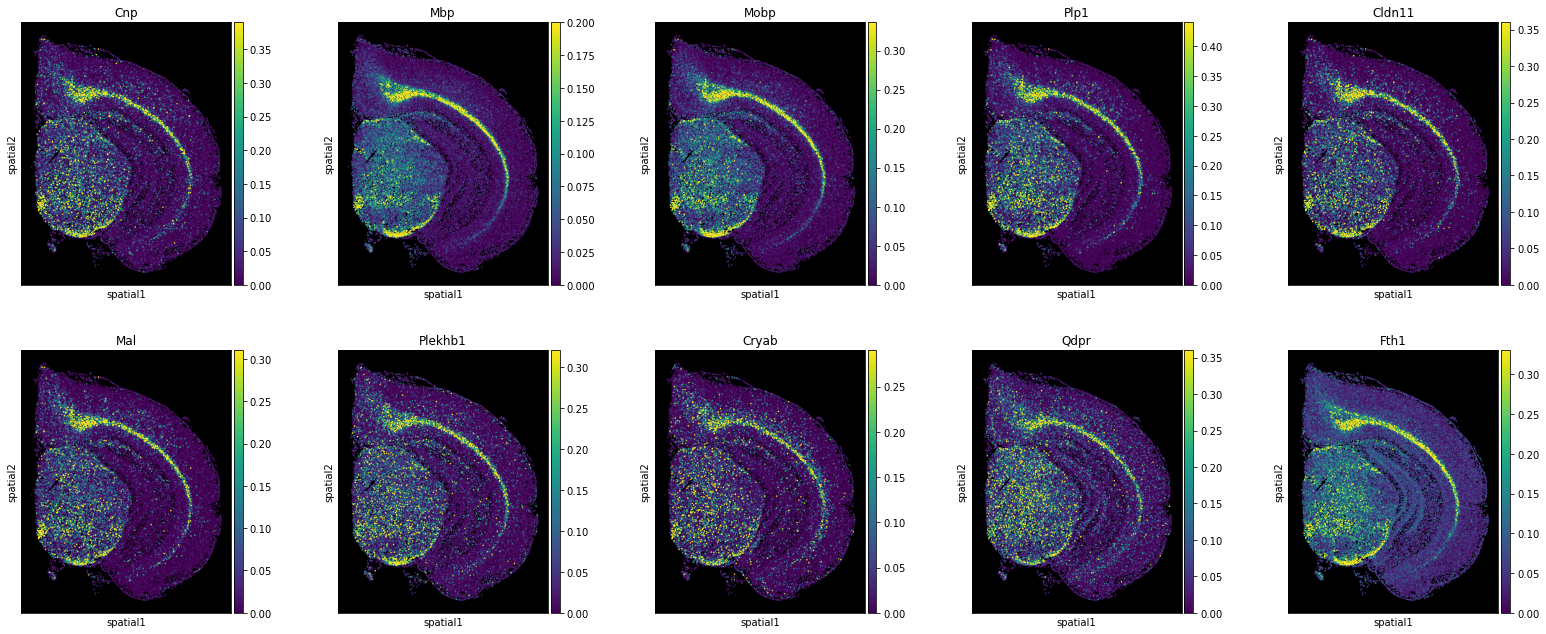

In [7]:
# Visualization of candidate marker genes
for k, v in Patterndict.items():
    print(k)
    print(v)
    with mpl.rc_context({'axes.facecolor':  'black',
                         'figure.figsize': [4.5, 5]}):
        sc.pl.spatial(adata, #cmap='magma',
                      layer='DenoisedX',
                      color=v,
                      ncols=5, size=1.5,
                      spot_size=50,
                      vmin=0, vmax='p99'
                     )

# Step3：Initial Pattern Recognition

In [8]:
# Construct the marker list by selecting 1-3 genes for each pattern 
# from the above candidate marker genes.
Patterndict = {
               "CTX": ['Mef2c', 'Arpp21'],
               "Mb": ['Mbp', 'Sparc', 'Tcf7l2'],
               "Th": ['Prkcd', 'Il31ra', 'Zic1'],
               "SNr": ['Slc6a3', 'Th', 'Slc18a2'],
               "Hip": ['Cpne6','Gpr161','Gm2115'],
               "FT": ['Mbp', 'Plp1','Cldn11']
              }

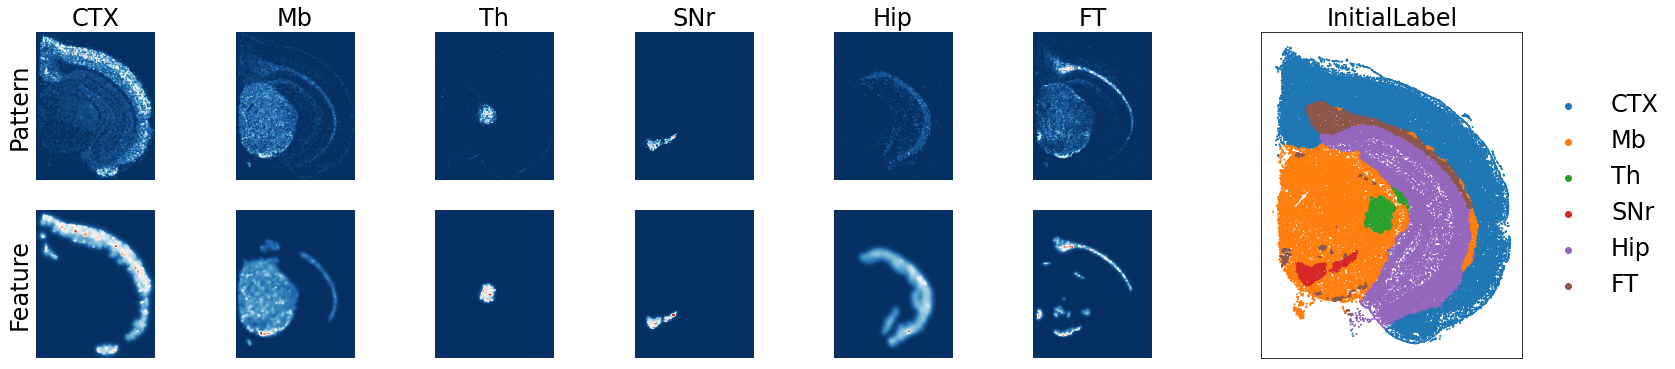

In [9]:
adata = po.AutoPatternRecognition(adata,
                                  Patterndict=Patterndict,
                                  config_path=config_path,
                                  param_tuning=False)

# Step4：Annotation Improvement

### There are too many space spots, so the ‘po.AnnotationImprovement’ is performed in three steps

---Create Spatial Graph: Done!
---Compute Spatial Energy: Done!
---Find K-Nearest Neighbor in UMAP: Done!
---Compute KNN Energy: Done!
---Compute Global Energy: Done!


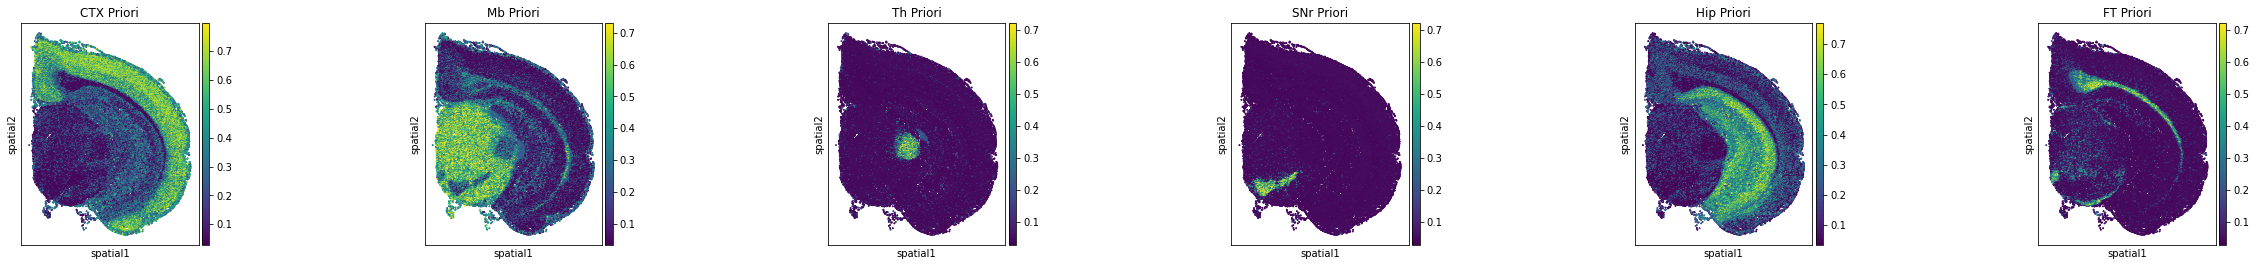

In [10]:
adata = po.PrioriInitialization(adata)

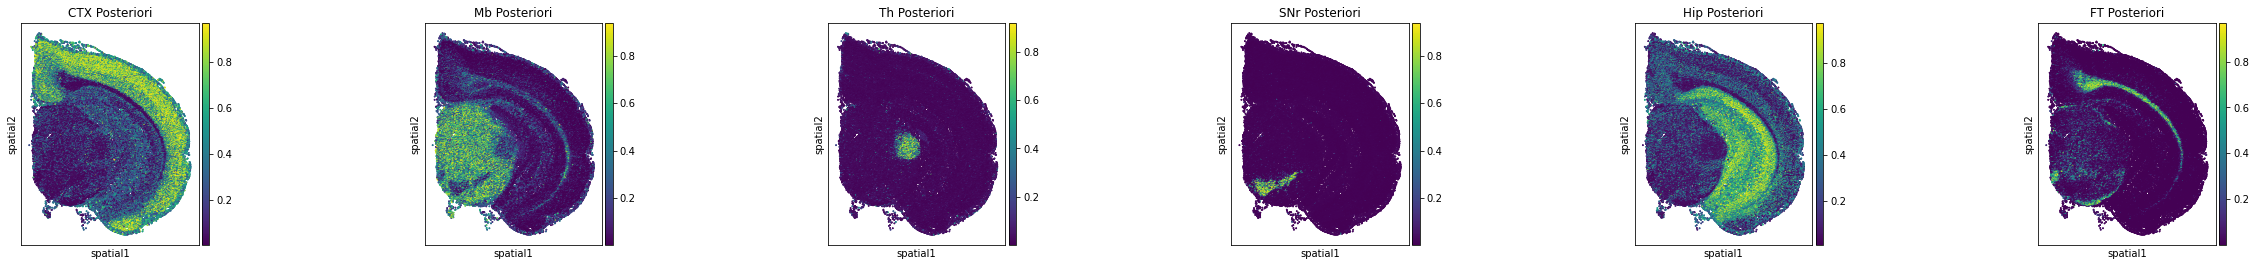

In [11]:
adata = po.PosterioriInference(adata)

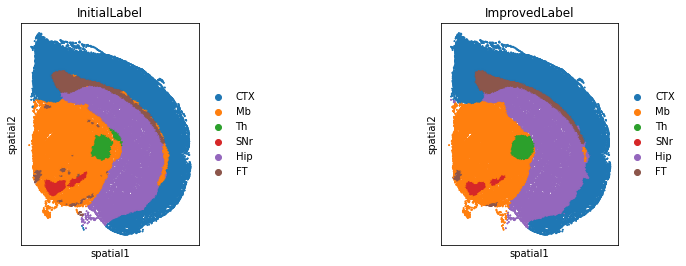

In [12]:
adata = po.LabelRenew(adata)

### Then you can take out any of these structures individually, such as the cortex, and continue to refine the annotations